In [10]:
from __future__ import print_function
import matplotlib
import os
from netCDF4 import num2date, date2num

from matplotlib.animation import FuncAnimation, writers
import copy
import pyart
import xray
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pyproj as Proj
from scipy.interpolate import RegularGridInterpolator
#import scipy.interpolate.griddata
%matplotlib inline

In [11]:
my_data = xray.open_mfdataset('/data/modal/wrfout_d01_2004-12-16_*', concat_dim='Time')
radar = pyart.io.read('/data/xsapr_test_case/XNW130928080000.RAW1HDW')

In [12]:
dx = my_data.DX
dy = my_data.DY
dn = -0.01

lat_0 = 18.
lon_0 = 62.
u_vel = my_data.data_vars['U']
shp = u_vel.shape
print(shp, my_data.variables['QCLOUD'].shape)
time = my_data.data_vars['Times']
lats = my_data.XLAT
lons = my_data.XLONG
levels = np.array([my_data.P.data[0, z, :, :].mean()/100.0 \
                   for z in range(my_data.P.data.shape[1])])
#y_array = np.linspace(0, (shp[2]-1)*dx,shp[2])
#x_array = np.linspace(0, (shp[3]-1)*dx,shp[3])
#n_array = np.linspace(1, (shp[1]-1)*dn,shp[1])

#fake z_array
#zero to 8km
x_array = np.linspace(-40000, 40000, shp[3])
y_array = np.linspace(-40000, 40000, shp[2])
z_array = np.linspace(0, 8000., shp[1])

(30, 99, 128, 129) (30, 99, 128, 128)


0.181236 -9.33113


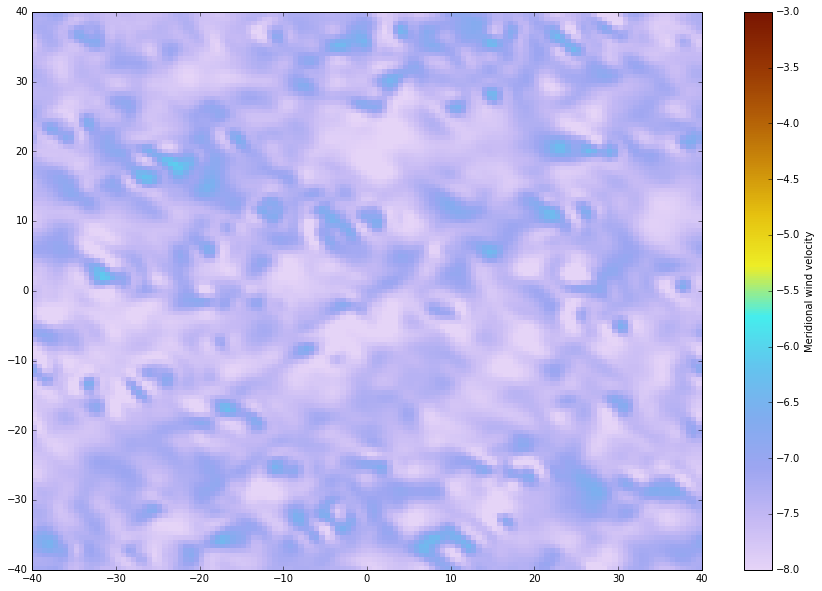

In [14]:
fig = plt.figure(figsize = [15,10])
print(u_vel.data.max(), u_vel.data.min())
plt.pcolormesh(x_array/1000.0, y_array/1000.0, 
               u_vel.data[5, 20, :,:], cmap = pyart.graph.cm.LangRainbow12,
              vmin = -8, vmax = -3)
cb = plt.colorbar()

cb.set_label('Meridional wind velocity')

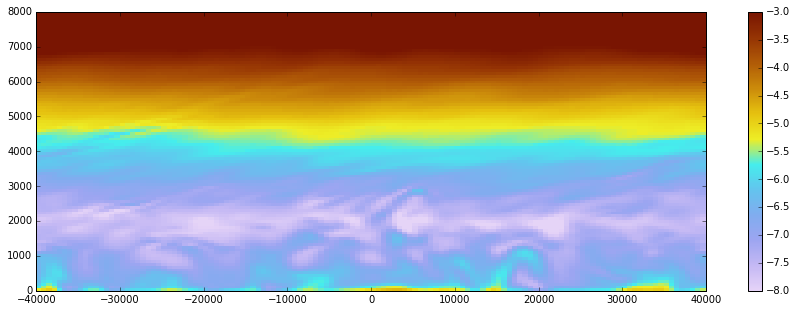

In [15]:
fig = plt.figure(figsize = [15,5])
plt.pcolormesh(x_array, z_array, u_vel.data[5, :, 110,:],
              cmap = pyart.graph.cm.LangRainbow12,
              vmin = -8, vmax = -3)
plt.colorbar()


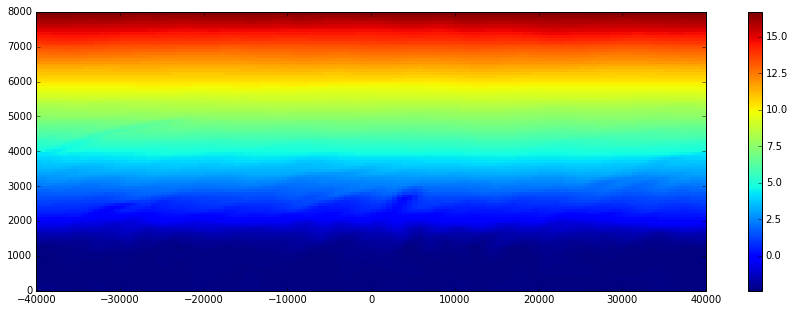

In [16]:
fig = plt.figure(figsize = [15,5])
plt.pcolormesh(x_array, z_array, my_data.variables['T'].data[5, :, 110,:])
plt.colorbar()


In [36]:
my_interpolating_function = RegularGridInterpolator((z_array, 
                                                     y_array, x_array), 
                                                    u_vel.values[0,::-1,:,:],
                                                   bounds_error = False,
                                                   fill_value = radar.fields['reflectivity']['_FillValue'])

In [37]:
want_x = np.ones(10000)*5000.0
want_y = np.ones(10000)*5000.0
want_z = np.linspace(0,4000,10000)


In [38]:
que = np.array([[want_z[i], want_y[i], want_x[i]] for i in range(len(want_x))])

In [39]:
#doneme = np.array([my_interpolating_function(que[i]) for i in range(len(want_x))])
doneme = my_interpolating_function(que)

(10000,)


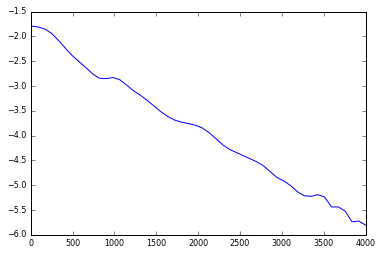

In [40]:
plt.plot(want_z,doneme)
print(doneme.shape)

In [25]:
radar.range['data'] = radar.range['data']/5.0

In [41]:
rx, ry, rz  = (radar.gate_x['data'].flatten(), 
              radar.gate_y['data'].flatten(),
              radar.gate_z['data'].flatten())

que2 = np.array([[rz[i], ry[i], rx[i]] for i in range(len(rz))])
doneme2 = my_interpolating_function(que2)
my_new_field = doneme2.reshape(radar.fields['reflectivity']['data'].shape)
mnf_masked = np.ma.masked_where(my_new_field == radar.fields['reflectivity']['_FillValue'],
                                my_new_field)
radar.add_field_like('velocity', 'U', 
                     mnf_masked, 
                     replace_existing = True)

{-98.0: ([<matplotlib.lines.Line2D at 0x1516893c8>],
   <matplotlib.text.Text at 0x151691710>]),
 -97.799999999999997: ([<matplotlib.lines.Line2D at 0x151689a58>],
  [<matplotlib.text.Text at 0x151691c50>]),
 -97.599999999999994: ([<matplotlib.lines.Line2D at 0x151688278>],
  [<matplotlib.text.Text at 0x1324b61d0>]),
 -97.399999999999991: ([<matplotlib.lines.Line2D at 0x151688a58>],
  [<matplotlib.text.Text at 0x1324b6710>]),
 -97.199999999999989: ([<matplotlib.lines.Line2D at 0x1516a8278>],
  [<matplotlib.text.Text at 0x1324b6c50>]),
 -96.999999999999986: ([<matplotlib.lines.Line2D at 0x1516a8a58>], [])}

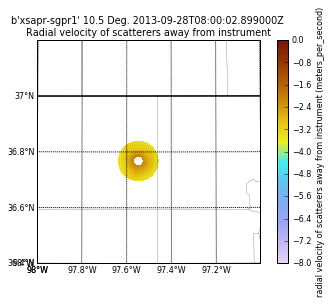

In [42]:
min_lon=-98.
max_lon=-97
min_lat=36.4
max_lat=37.2
lon_lines = np.arange(-98, -95, .2)
lat_lines = np.arange(34, 37, .2)

display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('U', vmin = -8, vmax = 0, sweep =10, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i',cmap = pyart.graph.cm.LangRainbow12)
display.basemap.drawstates()
display.basemap.drawparallels(lat_lines, labels=[True,False,False,False])
display.basemap.drawcounties()
display.basemap.drawmeridians(lon_lines,labels=[True,False,False,True])


In [43]:

grids = pyart.map.grid_from_radars(
         (radar,), grid_shape=(99, 128, 129),
        grid_limits=((1, 8000.0),(-40000, 40000), (-40000, 40000)),
        gridding_algo="map_gates_to_grid",
        weighting_function='BARNES')

In [44]:
print(u_vel.shape)

(30, 99, 128, 129)


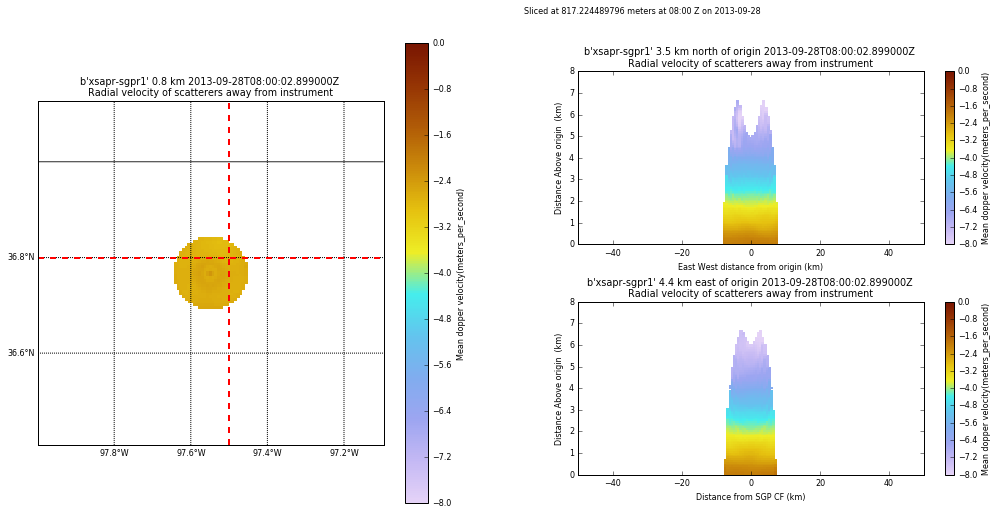

In [45]:
lon_lines = np.arange(-98, -95, .2)
lat_lines = np.arange(34, 37, .2)

display = pyart.graph.GridMapDisplay(grids)

# create the figure
font = {'size': 8}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=[15, 8])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .30]
y_cut_panel_axes = [0.55, 0.50, .4, .30]
colorbar_panel_axes = [0.05, 0.90, .4, .03]

min_lon=-98.
max_lon=-97
min_lat=36.4
max_lat=37.2

# parameters
level = 10
vmin = -8
vmax = 0
lat = 36.8
lon = -97.5

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = lon_lines, lat_lines= lat_lines )
display.plot_grid('U', level=level, vmin=vmin, 
                  vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
display.plot_crosshairs(lon=lon, lat=lat)

# plot the reanalysis on the basemap
# colorbar
#cbax = fig.add_axes(colorbar_panel_axes)
#display.plot_colorbar(cax=cbax)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('U', lon=lon, lat=lat, vmin=vmin, 
                             vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
ax2.set_xlabel('Distance from SGP CF (km)')
plt.ylim([0,8])
# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
display.plot_latitude_slice('U', lon=lon, lat=lat, 
                            vmin=vmin, vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
plt.ylim([0,8])
# add a title
slc_height = grids.axes['z_disp']['data'][level]
dts = num2date(grids.axes['time']['data'], grids.axes['time']['units'])
datestr = dts[0].strftime('%H:%M Z on %Y-%m-%d')
title = 'Sliced at ' + str(slc_height) + ' meters at ' + datestr
fig.text(0.5, 0.9, title)
plt.show()



In [46]:
print((grids.fields['U']['data'] - u_vel.values[0,:,:,:]).mean())

2.12382952269


In [47]:
ns = []
detail = []
sweeps = list(range(radar.nsweeps))
all_sweeps = sweeps
for i in [1,2,3,4]:
    ts = all_sweeps[0::i]
    new_radar = radar.extract_sweeps(ts)
    grids = pyart.map.grid_from_radars(
         (new_radar,), grid_shape=(99, 128, 129),
        grid_limits=((1, 8000.0),(-40000, 40000), (-40000, 40000)),
        gridding_algo="map_gates_to_grid",
        weighting_function='BARNES')
    ns.append(len(ts))
    detail.append((grids.fields['U']['data'] - u_vel.values[0,:,:,:]).mean())
    print((grids.fields['U']['data'] - u_vel.values[0,:,:,:]).mean())
    

for i in [5,3,4]:
    ts = np.delete(np.array(all_sweeps), np.arange(0, np.array(all_sweeps).size, i))
    new_radar = radar.extract_sweeps(ts)
    grids = pyart.map.grid_from_radars(
         (new_radar,), grid_shape=(99, 128, 129),
        grid_limits=((1, 8000.0),(-40000, 40000), (-40000, 40000)),
        gridding_algo="map_gates_to_grid",
        weighting_function='BARNES')
    ns.append(len(ts))
    detail.append((grids.fields['U']['data'] - u_vel.values[0,:,:,:]).mean())
    print((grids.fields['U']['data'] - u_vel.values[0,:,:,:]).mean())
    



2.12382952269
2.57901724906
2.59319253951
2.88089340883
2.2373490753
2.49877745749
2.25642653742


[22, 11, 8, 6, 17, 14, 16]
[2.1238295226918256, 2.5790172490569994, 2.5931925395143742, 2.8808934088282361, 2.2373490753024416, 2.4987774574933823, 2.2564265374245212]


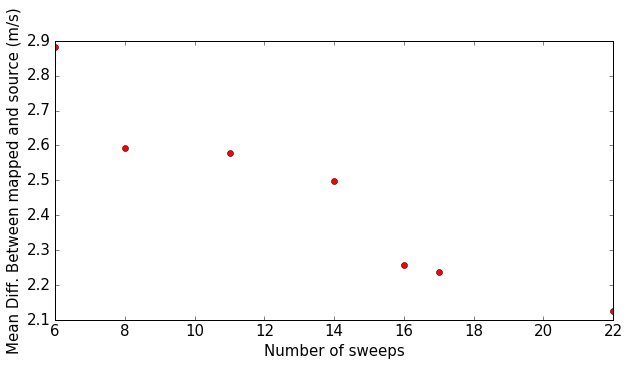

In [48]:
print(ns)
print(detail)
fig = plt.figure(figsize=[10,5])
plt.plot(ns, detail, 'ro')
plt.xlabel('Number of sweeps', size = 15)
plt.ylabel('Mean Diff. Between mapped and source (m/s)', size = 15)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)


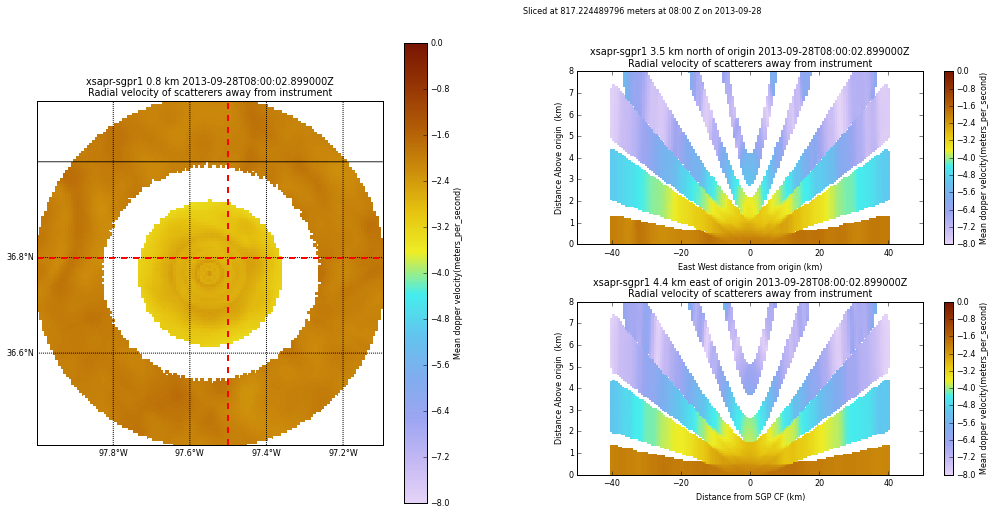

In [274]:
lon_lines = np.arange(-98, -95, .2)
lat_lines = np.arange(34, 37, .2)

display = pyart.graph.GridMapDisplay(grids)

# create the figure
font = {'size': 8}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=[15, 8])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .30]
y_cut_panel_axes = [0.55, 0.50, .4, .30]
colorbar_panel_axes = [0.05, 0.90, .4, .03]

min_lon=-98.
max_lon=-97
min_lat=36.4
max_lat=37.2

# parameters
level = 10
vmin = -8
vmax = 0
lat = 36.8
lon = -97.5

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = lon_lines, lat_lines= lat_lines )
display.plot_grid('U', level=level, vmin=vmin, 
                  vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
display.plot_crosshairs(lon=lon, lat=lat)

# plot the reanalysis on the basemap
# colorbar
#cbax = fig.add_axes(colorbar_panel_axes)
#display.plot_colorbar(cax=cbax)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('U', lon=lon, lat=lat, vmin=vmin, 
                             vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
ax2.set_xlabel('Distance from SGP CF (km)')
plt.ylim([0,8])
# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
display.plot_latitude_slice('U', lon=lon, lat=lat, 
                            vmin=vmin, vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
plt.ylim([0,8])
# add a title
slc_height = grids.axes['z_disp']['data'][level]
dts = num2date(grids.axes['time']['data'], grids.axes['time']['units'])
datestr = dts[0].strftime('%H:%M Z on %Y-%m-%d')
title = 'Sliced at ' + str(slc_height) + ' meters at ' + datestr
fig.text(0.5, 0.9, title)
plt.show()



In [310]:
shp = my_data.variables['QCLOUD'].shape
x_array = np.linspace(-40000, 40000, shp[3])
y_array = np.linspace(-40000, 40000, shp[2])
z_array = np.linspace(0, 8000., shp[1])

my_interpolating_function = RegularGridInterpolator((z_array, 
                                        y_array, x_array), 
                                        my_data.variables['QCLOUD'].values[0,:,:,:],
                                        bounds_error = False,
                                        fill_value = radar.fields['reflectivity']['_FillValue'])
rx, ry, rz  = (radar.gate_x['data'].flatten(), 
              radar.gate_y['data'].flatten(),
              radar.gate_z['data'].flatten())

que2 = np.array([[rz[i], ry[i], rx[i]] for i in range(len(rz))])
doneme2 = my_interpolating_function(que2)
my_new_field = doneme2.reshape(radar.fields['reflectivity']['data'].shape)
mnf_masked = np.ma.masked_where(my_new_field == radar.fields['reflectivity']['_FillValue'],
                                my_new_field)
radar.add_field_like('velocity', 'QCLOUD', 
                     mnf_masked, 
                     replace_existing = True)

{-98.0: ([<matplotlib.lines.Line2D at 0x129e9dbd0>],
  [<matplotlib.text.Text at 0x129eadf10>]),
 -97.799999999999997: ([<matplotlib.lines.Line2D at 0x129e8e2d0>],
  [<matplotlib.text.Text at 0x129ea2410>]),
 -97.599999999999994: ([<matplotlib.lines.Line2D at 0x129e8e890>],
  [<matplotlib.text.Text at 0x129ea2850>]),
 -97.399999999999991: ([<matplotlib.lines.Line2D at 0x129e8ee50>],
  [<matplotlib.text.Text at 0x129ea2c90>]),
 -97.199999999999989: ([<matplotlib.lines.Line2D at 0x129ead450>],
  [<matplotlib.text.Text at 0x146bd2110>]),
 -96.999999999999986: ([<matplotlib.lines.Line2D at 0x129eada10>], [])}

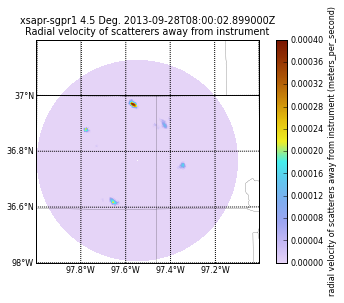

In [315]:
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('QCLOUD', vmin = 0., vmax = 0.0004, sweep = 4, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i',cmap = pyart.graph.cm.LangRainbow12)
display.basemap.drawstates()
display.basemap.drawparallels(lat_lines, labels=[True,False,False,False])
display.basemap.drawcounties()
display.basemap.drawmeridians(lon_lines,labels=[True,False,False,True])


In [316]:
grids = pyart.map.grid_from_radars(
         (radar,), grid_shape=(99, 129, 129),
        grid_limits=((1, 8000.0),(-40000, 40000), (-40000, 40000)),
        gridding_algo="map_gates_to_grid",
        weighting_function='BARNES')

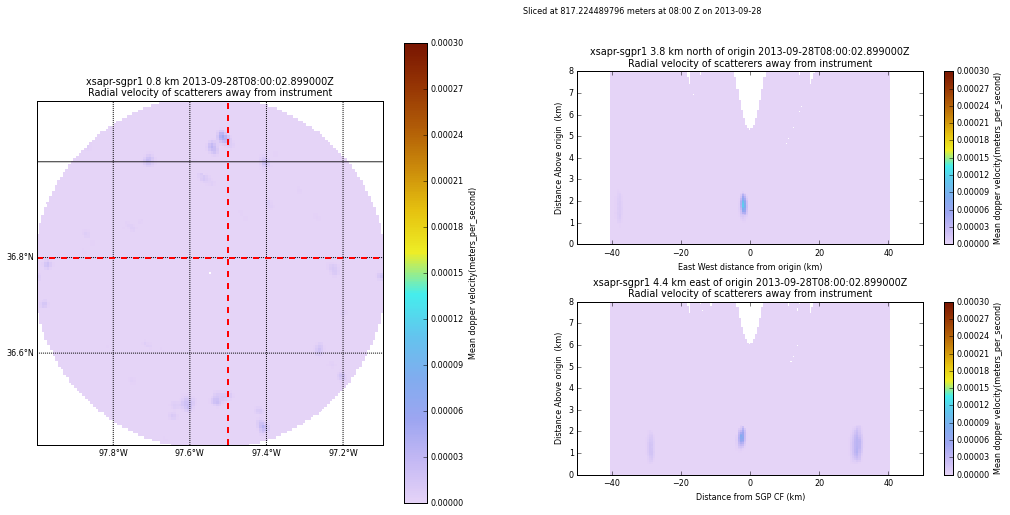

In [318]:
lon_lines = np.arange(-98, -95, .2)
lat_lines = np.arange(34, 37, .2)

display = pyart.graph.GridMapDisplay(grids)

# create the figure
font = {'size': 8}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=[15, 8])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .30]
y_cut_panel_axes = [0.55, 0.50, .4, .30]
colorbar_panel_axes = [0.05, 0.90, .4, .03]

min_lon=-98.
max_lon=-97
min_lat=36.4
max_lat=37.2

# parameters
level = 10
vmin = 0
vmax = 0.0003
lat = 36.8
lon = -97.5

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = lon_lines, lat_lines= lat_lines )
display.plot_grid('QCLOUD', level=level, vmin=vmin, 
                  vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
display.plot_crosshairs(lon=lon, lat=lat)

# plot the reanalysis on the basemap
# colorbar
#cbax = fig.add_axes(colorbar_panel_axes)
#display.plot_colorbar(cax=cbax)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('QCLOUD', lon=lon, lat=lat, vmin=vmin, 
                             vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
ax2.set_xlabel('Distance from SGP CF (km)')
plt.ylim([0,8])
# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
display.plot_latitude_slice('QCLOUD', lon=lon, lat=lat, 
                            vmin=vmin, vmax=vmax, cmap = pyart.graph.cm.LangRainbow12)
plt.ylim([0,8])
# add a title
slc_height = grids.axes['z_disp']['data'][level]
dts = num2date(grids.axes['time']['data'], grids.axes['time']['units'])
datestr = dts[0].strftime('%H:%M Z on %Y-%m-%d')
title = 'Sliced at ' + str(slc_height) + ' meters at ' + datestr
fig.text(0.5, 0.9, title)
plt.show()



In [50]:
radar = pyart.io.read('/data/xsapr_test_case/XNW130928080000.RAW1HDW')
radar.range['data'] = 1.5*radar.range['data']/10.
my_data = xray.open_mfdataset('/data/modal/wrfout_d01_2004-12-16_*', concat_dim='Time')


In [51]:
shp = my_data.variables['QCLOUD'].shape
x_array = np.linspace(-6000, 6000, shp[3])
y_array = np.linspace(-6000, 6000, shp[2])
z_array = np.linspace(0, 4000., shp[1])

my_interpolating_function = RegularGridInterpolator((z_array, 
                                        y_array, x_array), 
                                        my_data.variables['QCLOUD'].values[0,:,:,:],
                                        bounds_error = False,
                                        fill_value = radar.fields['reflectivity']['_FillValue'])
rx, ry, rz  = (radar.gate_x['data'].flatten(), 
              radar.gate_y['data'].flatten(),
              radar.gate_z['data'].flatten())

que2 = np.array([[rz[i], ry[i], rx[i]] for i in range(len(rz))])
doneme2 = my_interpolating_function(que2)
my_new_field = doneme2.reshape(radar.fields['reflectivity']['data'].shape)
mnf_masked = np.ma.masked_where(my_new_field == radar.fields['reflectivity']['_FillValue'],
                                my_new_field)
radar.add_field_like('reflectivity', 'QCLOUD', 
                     mnf_masked*1000.0, 
                     replace_existing = True)
radar.fields['QCLOUD']['units'] = 'g/kg'
radar.fields['QCLOUD']['standard_name'] = 'Mixing Ratio'
radar.fields['QCLOUD']['long_name'] = 'Cloud Liquid Water mixing ratio'


{-97.620000000000005: ([<matplotlib.lines.Line2D at 0x11b418710>],
   <matplotlib.text.Text at 0x11b425c50>]),
 -97.600000000000009: ([<matplotlib.lines.Line2D at 0x11b418f98>],
  [<matplotlib.text.Text at 0x11b42b1d0>]),
 -97.580000000000013: ([<matplotlib.lines.Line2D at 0x11b41b7b8>],
  [<matplotlib.text.Text at 0x11b42b710>]),
 -97.560000000000016: ([<matplotlib.lines.Line2D at 0x11b41bf98>],
  [<matplotlib.text.Text at 0x11b42bc50>]),
 -97.54000000000002: ([<matplotlib.lines.Line2D at 0x11b41d7b8>],
  [<matplotlib.text.Text at 0x1511111d0>]),
 -97.520000000000024: ([<matplotlib.lines.Line2D at 0x11b41df98>],
  [<matplotlib.text.Text at 0x151111710>]),
 -97.500000000000028: ([<matplotlib.lines.Line2D at 0x11b4217b8>],
  [<matplotlib.text.Text at 0x151111c50>]),
 -97.480000000000032: ([<matplotlib.lines.Line2D at 0x11b421f98>], [])}

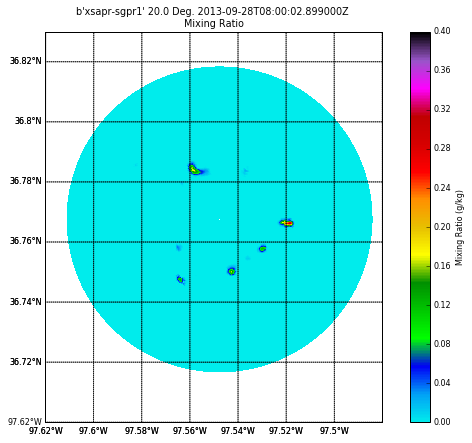

In [52]:
min_lon=-97.62
max_lon=-97.48
min_lat=36.7
max_lat=36.83
lon_lines = np.arange(min_lon, max_lon, .02)
lat_lines = np.arange(min_lat, max_lat, .02)

fig = plt.figure(figsize = [10,7])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('QCLOUD', vmin = 0., vmax = 0.4, sweep = 15, 
                     min_lon = min_lon, max_lon = max_lon, 
                     min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i',cmap = pyart.graph.cm.NWSRef,
                    lat_lines = lat_lines, lon_lines = lon_lines)

display.basemap.drawstates()
display.basemap.drawparallels(lat_lines, labels=[True,False,False,False])
display.basemap.drawcounties()
display.basemap.drawmeridians(lon_lines,labels=[True,False,False,True])


In [53]:
grids = pyart.map.grid_from_radars(
         (radar,), grid_shape=(99, 128, 128),
        grid_limits=((0, 4000.0),(-6000, 6000), (-6000, 6000)),
        gridding_algo="map_gates_to_grid",
        weighting_function='CRESSMAN', min_radius=10.0,)

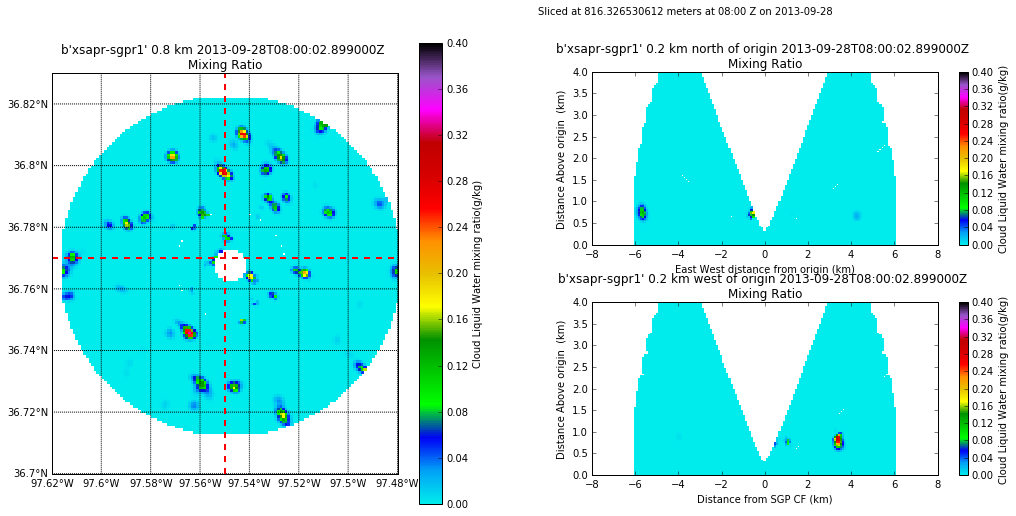

In [54]:

display = pyart.graph.GridMapDisplay(grids)

# create the figure
font = {'size': 10}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=[15, 8])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .30]
y_cut_panel_axes = [0.55, 0.50, .4, .30]
colorbar_panel_axes = [0.05, 0.90, .4, .03]

# parameters
level = 20
vmin = 0
vmax = 0.4
lat = 36.77
lon = -97.55

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = lon_lines, lat_lines= lat_lines,
                     min_lon = min_lon, max_lon = max_lon,
                     min_lat = min_lat, max_lat = max_lat,
                    auto_range = False)
display.plot_grid('QCLOUD', level=level, vmin=vmin, 
                  vmax=vmax, cmap = pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# plot the reanalysis on the basemap
# colorbar
#cbax = fig.add_axes(colorbar_panel_axes)
#display.plot_colorbar(cax=cbax)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('QCLOUD', lon=lon, lat=lat, vmin=vmin, 
                             vmax=vmax, cmap = pyart.graph.cm.NWSRef)
ax2.set_xlabel('Distance from SGP CF (km)')
plt.ylim([0,4])
# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
display.plot_latitude_slice('QCLOUD', lon=lon, lat=lat, 
                            vmin=vmin, vmax=vmax, cmap = pyart.graph.cm.NWSRef)
plt.ylim([0,4])
# add a title
slc_height = grids.axes['z_disp']['data'][level]
dts = num2date(grids.axes['time']['data'], grids.axes['time']['units'])
datestr = dts[0].strftime('%H:%M Z on %Y-%m-%d')
title = 'Sliced at ' + str(slc_height) + ' meters at ' + datestr
fig.text(0.5, 0.9, title)
plt.show()



In [55]:
my_new_cool = copy.deepcopy(grids.fields['QCLOUD'])
my_new_cool['data'] = my_data.variables['QCLOUD'].values[0,:,:,:]*1000.0
grids.add_field('QCLOUD_orig', my_new_cool, replace_existing = True)

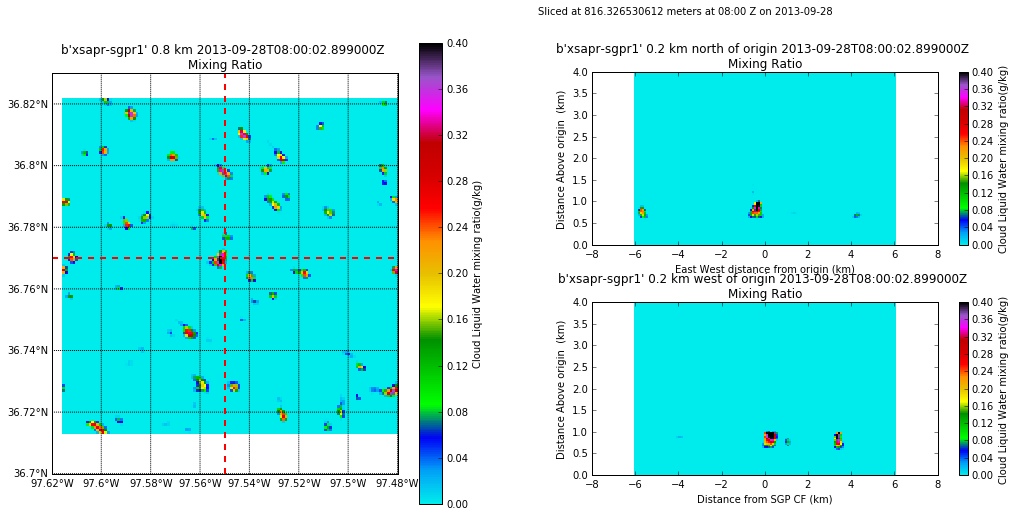

In [56]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 8])

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = lon_lines, lat_lines= lat_lines,
                     min_lon = min_lon, max_lon = max_lon,
                     min_lat = min_lat, max_lat = max_lat,
                    auto_range = False)
display.plot_grid('QCLOUD_orig', level=level, vmin=vmin, 
                  vmax=vmax, cmap = pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# plot the reanalysis on the basemap
# colorbar
#cbax = fig.add_axes(colorbar_panel_axes)
#display.plot_colorbar(cax=cbax)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('QCLOUD_orig', lon=lon, lat=lat, vmin=vmin, 
                             vmax=vmax, cmap = pyart.graph.cm.NWSRef)
ax2.set_xlabel('Distance from SGP CF (km)')
plt.ylim([0,4])
# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
display.plot_latitude_slice('QCLOUD_orig', lon=lon, lat=lat, 
                            vmin=vmin, vmax=vmax, cmap = pyart.graph.cm.NWSRef)
plt.ylim([0,4])
# add a title
slc_height = grids.axes['z_disp']['data'][level]
dts = num2date(grids.axes['time']['data'], grids.axes['time']['units'])
datestr = dts[0].strftime('%H:%M Z on %Y-%m-%d')
title = 'Sliced at ' + str(slc_height) + ' meters at ' + datestr
fig.text(0.5, 0.9, title)
plt.show()



In [57]:
ns = []
detail = []
sweeps = list(range(radar.nsweeps))
all_sweeps = sweeps
for i in [1,2,3,4]:
    ts = all_sweeps[0::i]
    new_radar = radar.extract_sweeps(ts)
    dgrids = pyart.map.grid_from_radars(
             (new_radar,), grid_shape=(99, 128, 128),
            grid_limits=((0, 4000.0),(-6000, 6000), (-6000, 6000)),
            gridding_algo="map_gates_to_grid",
            weighting_function='CRESSMAN', min_radius=10.0)
    ns.append(len(ts))
    detail.append((np.abs(dgrids.fields['QCLOUD']['data'] - \
                   grids.fields['QCLOUD_orig']['data'])).mean())
   

In [58]:
for i in [5,3,4]:
    ts = np.delete(np.array(all_sweeps), np.arange(0, np.array(all_sweeps).size, i))
    new_radar = radar.extract_sweeps(ts)
    dgrids = pyart.map.grid_from_radars(
             (new_radar,), grid_shape=(99, 128, 128),
            grid_limits=((0, 4000.0),(-6000, 6000), (-6000, 6000)),
            gridding_algo="map_gates_to_grid",
            weighting_function='CRESSMAN', min_radius=10.0)
    ns.append(len(ts))
    detail.append((np.abs(dgrids.fields['QCLOUD']['data'] - \
                   grids.fields['QCLOUD_orig']['data'])).mean())
 

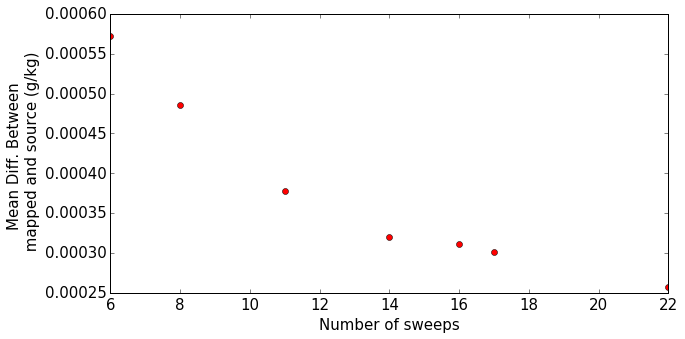

In [59]:
fig = plt.figure(figsize=[10,5])
plt.plot(ns, detail, 'ro')
plt.xlabel('Number of sweeps', size = 15)
plt.ylabel('Mean Diff. Between \n mapped and source (g/kg)', size = 15)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)


In [99]:
def cloud_fraction(pyart_grid, var, level):
    cf = np.zeros(pyart_grid.nz)
    for i in range(pyart_grid.nz):
       cf[i] = len(np.where(pyart_grid.fields[var]['data'][i,:,:] > level)[0])/(pyart_grid.nx*pyart_grid.ny)
    return cf
    

In [100]:
orig = cloud_fraction(grids,'QCLOUD_orig', 0.0 )

In [124]:
ns = []
detail = []
cf = np.zeros([grids.nz, 7])
sweeps = list(range(radar.nsweeps))
all_sweeps = sweeps
k = 0
for i in [1,2,3,4]:
    ts = all_sweeps[0::i]
    new_radar = radar.extract_sweeps(ts)
    dgrids = pyart.map.grid_from_radars(
             (new_radar,), grid_shape=(99, 128, 128),
            grid_limits=((0, 4000.0),(-6000, 6000), (-6000, 6000)),
            gridding_algo="map_gates_to_grid",
            weighting_function='CRESSMAN', min_radius=10.0)
    ns.append(len(ts))
    detail.append((np.abs(dgrids.fields['QCLOUD']['data'] - \
                   grids.fields['QCLOUD_orig']['data'])).mean())
    cf[:,k] = cloud_fraction(dgrids,'QCLOUD', 0.0 )
    k = k+1

for i in [5,3,4]:
    ts = np.delete(np.array(all_sweeps), np.arange(0, np.array(all_sweeps).size, i))
    new_radar = radar.extract_sweeps(ts)
    dgrids = pyart.map.grid_from_radars(
             (new_radar,), grid_shape=(99, 128, 128),
            grid_limits=((0, 4000.0),(-6000, 6000), (-6000, 6000)),
            gridding_algo="map_gates_to_grid",
            weighting_function='CRESSMAN', min_radius=10.0)
    ns.append(len(ts))
    detail.append((np.abs(dgrids.fields['QCLOUD']['data'] - \
                   grids.fields['QCLOUD_orig']['data'])).mean())
    cf[:,k] = cloud_fraction(dgrids,'QCLOUD', 0.0 )
    k = k+1
 

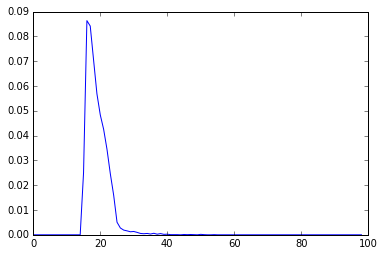

In [123]:
plt.plot(orig)

In [120]:
cgoo = np.argsort(ns)
cf_s = (cf.T[cgoo]).T
ns_s = np.array(ns)[cgoo]

In [121]:
cf_s.shape
points = 19.5
>>> total = 22
>>> 'Correct answers: {:.2%}'.format(points/total)
'Correct answers: 88.64%'

(99, 7)

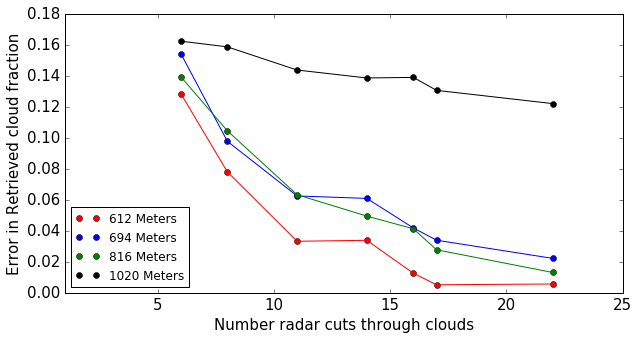

In [138]:
levels = [15,17,20,25]


sym = ['ro', 'bo', 'go', 'ko']
ln = ['r-', 'b-', 'g-', 'k-']
fig = plt.figure(figsize=[10,5])
for i in range(len(levels)):
    lab = '{0:.0f} Meters'.format(grids.z['data'][levels[i]]) 
    error = np.abs(cf_s[levels[i],:] - 0.2)
    plt.plot(ns_s, error, sym[i], label = lab)
    plt.plot(ns_s, error, ln[i])
    
plt.xlabel('Number radar cuts through clouds', size = 15)
plt.ylabel('Error in Retrieved cloud fraction', size = 15)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.xlim([1,25])
plt.legend(loc=3)


In [132]:
plt.legend?

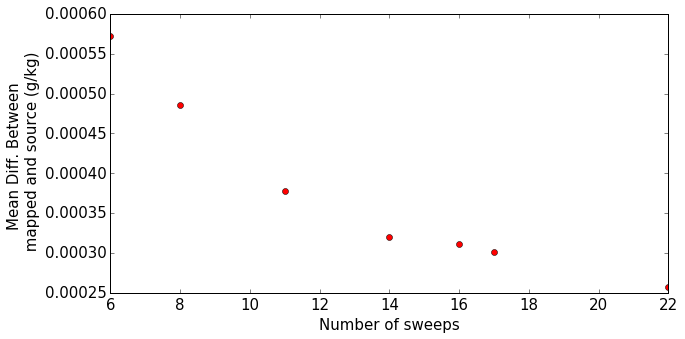

In [87]:
fig = plt.figure(figsize=[10,5])
plt.plot(ns, detail, 'ro')
plt.xlabel('Number of sweeps', size = 15)
plt.ylabel('Mean Diff. Between \n mapped and source (g/kg)', size = 15)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
